In [567]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Governing choices for search
N_FOLDS = 5
MAX_EVALS = 5

In [568]:
features = pd.read_csv('../data/processed/NSQIP_Clean2.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
#features = features.sample(n = 1500, random_state = 0)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['READMISSION1'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['READMISSION1', 'Unnamed: 0', 'index.1', 'index'])
features.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features.columns]

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 300, random_state = 0)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (1234, 49)
Test shape:  (300, 49)


,SMOKE,HXCOPD,HYPERMED,DISCANCR,WNDINF,STEROID,WTLOSS,EMERGNCY,RETURNOR,BLEEDIS_0_0,...,OPTIME,TOTHLOS,PRSODM,PRBUN,PRCREAT,PRALBUM,PRPLATE,PRPTT,PRINR,PRPT
901,0,0,0,0,0,0,0,0,0.0,1.0,...,-0.068489,-0.279138,0.339423,0.157647,0.290120,1.202131,-0.402474,0.747769,0.588994,-0.429450
276,0,0,0,0,0,0,0,0,0.0,1.0,...,0.256559,-0.279138,0.339423,0.414863,0.298832,-0.839085,-0.216625,0.625117,0.591279,-0.429450
618,0,0,1,0,0,0,0,0,0.0,1.0,...,-0.865381,-0.056836,0.323485,0.311977,0.307908,-0.839085,0.128522,0.702581,0.584651,-0.429450
184,0,0,0,0,0,0,0,0,1.0,1.0,...,0.099277,1.165825,0.339423,0.183369,0.294476,1.192280,0.146222,0.755838,0.588994,-0.429450
1034,0,0,0,0,0,0,0,0,0.0,0.0,...,-0.739556,0.387768,0.323485,0.234812,0.297017,1.184399,0.624118,0.652552,0.586708,2.612217


In [569]:
model = lgb.LGBMClassifier(random_state=0)

# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [570]:
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
                    early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


The maximium ROC AUC in cross validation was 0.58868 with std of 0.08794.
The ideal number of iterations was 16.


In [571]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.76148 ROC AUC on the test set.


In [572]:
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    print(cv_results)
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

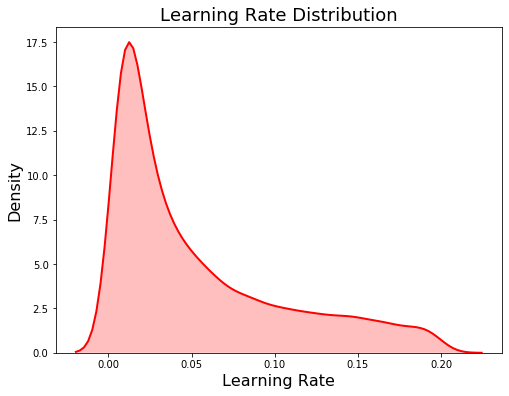

In [573]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

learning_rate_dist = []


# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

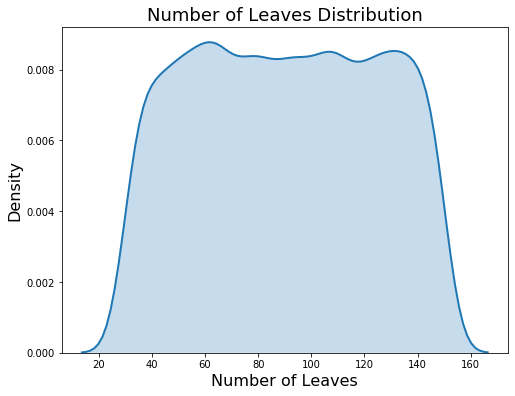

In [574]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

In [575]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.8360734932331254}}

In [576]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

hyperparams

{'boosting_type': 'dart', 'subsample': 0.8360734932331254}

In [577]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

In [578]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6434871942682213,
 'is_unbalance': True,
 'learning_rate': 0.03363083282339374,
 'min_child_samples': 95.0,
 'num_leaves': 68.0,
 'reg_alpha': 0.43269132163030677,
 'reg_lambda': 0.728857673729341,
 'subsample_for_bin': 220000.0,
 'subsample': 0.7292224349390166}

In [580]:
import csv 

# Create a new file and open a connection
OUT_FILE = '../reports/optimization/bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

{'auc-mean': [0.4776559700210753, 0.5029023804881672, 0.5152066273477611, 0.5093530658997855, 0.5051096008690081, 0.5083842807936199, 0.509595211402947, 0.511481602048111, 0.5069620748962482, 0.5010378369031372, 0.5091799721935957, 0.5065203464891513, 0.5102924894855583, 0.5212636014632019, 0.518447593747969, 0.5168636383681957, 0.5179084674911103, 0.5220575520615733, 0.5265211124418572, 0.5208958281109285, 0.5223716216843532, 0.5274378185666937, 0.5279024385148874, 0.5327501067691651, 0.5370623624766733, 0.5380338458253258, 0.5395239719986259, 0.5397599086427318, 0.5441695912133618, 0.5415759709030815, 0.5444740574139579, 0.5434869068508666, 0.542753275028085, 0.5416472857421385, 0.5425630054127325, 0.5440405397877615, 0.5439869811250685, 0.5451567417764533, 0.5456235667400124, 0.5456379573666081, 0.5444334387098572, 0.5437988584983613, 0.5461910100363015, 0.5448061443333426, 0.5461877025132533, 0.5453409185861906, 0.5470686061517609, 0.5479257768617293, 0.546852862806265, 0.547232589

In [581]:
from hyperopt import tpe
from hyperopt import Trials

# Create the algorithm
tpe_algorithm = tpe.suggest

# Record results
trials = Trials()

In [582]:
# Create a file and open a connection
OUT_FILE = '../reports/optimization/bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

In [583]:
from hyperopt import fmin

global  ITERATION

In [584]:
ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



{'auc-mean': [0.4640043427197355, 0.49832830821936885, 0.4909852588920146, 0.4818750928427523, 0.4818750928427523, 0.4818750928427523, 0.4818750928427523, 0.4818750928427523, 0.4818750928427523, 0.4818750928427523, 0.4818750928427523, 0.4818750928427523, 0.4818750928427523, 0.4818750928427523, 0.4818750928427523, 0.47918851372680094, 0.4740803054990762, 0.47918851372680094, 0.48759658547567986, 0.48580286350258567, 0.48580286350258567, 0.48759658547567986, 0.48580286350258567, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.48759658547567986, 0.4876713238912254, 0.4876713238912254, 0.4876713238912254, 0.487671323891225

C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



{'auc-mean': [0.4689313915271704, 0.4834680133507877, 0.4834680133507877, 0.47380804412816013, 0.47380804412816013, 0.47380804412816013, 0.47380804412816013, 0.47380804412816013, 0.47380804412816013, 0.47380804412816013, 0.4864575209592513, 0.4864575209592513, 0.4864575209592513, 0.4864575209592513, 0.4864575209592513, 0.4864575209592513, 0.4864575209592513, 0.4864575209592513, 0.4718835299278612, 0.4718835299278612, 0.4718835299278612, 0.4695737473191655, 0.4695737473191655, 0.4695737473191655, 0.4695737473191655, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.47052909923961783, 0.47052909923961783, 0.47052909923961783, 0.47052909923961783, 0.47052909923961783, 0.47052909923961783, 0.47052909923961783, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135309027, 0.4685014135

C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



{'auc-mean': [0.529291656221857, 0.5444839799831026, 0.5444839799831026, 0.5308743060004272, 0.5269803068917175, 0.5212752938473109, 0.5150471409074451, 0.5180091148372002, 0.5117032931324216, 0.5093645842037342, 0.5097052010509799, 0.5095090707368929, 0.5071455843987038, 0.5140457157711984, 0.522089669851173, 0.5225374620505251, 0.52150052456155, 0.5225709434680482, 0.5229074404181637, 0.5214251478520829, 0.5205516716337539, 0.5234483074766269, 0.5257050826764709, 0.5268525610673203, 0.5258592016451736, 0.5234459283811009, 0.5247669646919013, 0.5251279489179177, 0.5266873589950701, 0.5251209857115005, 0.5247685314133452, 0.5275928659629185, 0.526262893537216, 0.5252292635712893, 0.5252292635712893, 0.5242527899247046, 0.5222478506902858, 0.5244929625193809, 0.5255590874485884, 0.5240604313474269, 0.522408584705085, 0.521043796247296, 0.5210827902032328, 0.5220532870976428, 0.5216795950199147, 0.521601607108041, 0.521601607108041, 0.521835570843662, 0.5217185889758515, 0.52179657688772

C:\Users\brend\.conda\envs\NSQIP\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



{'auc-mean': [0.5289522579357342, 0.5131597057813182, 0.5208415151008736, 0.5131597057813182, 0.5156943129172121, 0.5149648300049207, 0.5293324780194785, 0.5296444296669731, 0.5271098225310792, 0.5394852681762898, 0.5369506610403959, 0.5369506610403959, 0.529346027258632, 0.5331203172436844, 0.5331203172436844, 0.5292712888430865, 0.5325045376895152, 0.5331284409845045, 0.5294028934443733, 0.5346297082880724, 0.5311592462096947, 0.5329675909162651, 0.5297392163143284, 0.5325224099193197, 0.534133811937721, 0.5310321676925791, 0.5307337652842381, 0.5307337652842381, 0.5314437802319212, 0.5318548415174219, 0.5320416875562859, 0.5326622543148669, 0.535578677269309, 0.5354292004382178, 0.5354292004382178, 0.5354292004382178, 0.5342333857894884, 0.5355471107335507, 0.5313185875832104, 0.5342707549972612, 0.5342707549972612, 0.533841821481956, 0.5351871129617767, 0.5326979987744757, 0.5333511475364175, 0.5320058560565969, 0.5326236665459712, 0.5323519274155364, 0.5334356344409474, 0.53313668

{'boosting_type': 0,
 'colsample_by_tree': 0.7825989760319382,
 'gdbt_subsample': 0.7763743961618927,
 'is_unbalance': 0,
 'learning_rate': 0.20840610544438354,
 'min_child_samples': 185.0,
 'num_leaves': 146.0,
 'reg_alpha': 0.6436104591634086,
 'reg_lambda': 0.19488844030664643,
 'subsample_for_bin': 140000.0}

In [585]:
results = pd.read_csv(OUT_FILE)
results

,loss,hyperparameters,iteration,runtime,score
0,0.499433,"{'boosting_type': 'dart', 'colsample_bytree': ...",1,82.964904,0.500567
1,0.527715,"{'boosting_type': 'dart', 'colsample_bytree': ...",2,72.942222,0.472285
2,0.471130,"{'boosting_type': 'dart', 'colsample_bytree': ...",3,83.156329,0.528870
3,0.480689,"{'boosting_type': 'dart', 'colsample_bytree': ...",4,87.171370,0.519311
4,0.432964,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",5,0.315707,0.567036


In [562]:
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    
    new_results = results.copy()
    # String to dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, 
                                        new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(new_results['hyperparameters']):
        print(hyp)
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [563]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results

The highest cross validation score from Bayesian was 0.61510 found on iteration 11.
ROC AUC from Bayesian on test data = 0.75247.
{'boosting_type': 'dart', 'colsample_bytree': 0.9435557973857587, 'is_unbalance': True, 'learning_rate': 0.08484861859319581, 'min_child_samples': 20, 'num_leaves': 121, 'reg_alpha': 0.8671439702303205, 'reg_lambda': 0.7226458208140685, 'subsample_for_bin': 140000, 'subsample': 0.9212942216347493, 'n_estimators': 10000}
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8372407592600555, 'is_unbalance': False, 'learning_rate': 0.07588441296938199, 'min_child_samples': 70, 'num_leaves': 73, 'reg_alpha': 0.3533743993213798, 'reg_lambda': 0.7500062602590154, 'subsample_for_bin': 160000, 'subsample': 0.5592208956068351, 'n_estimators': 246}
{'boosting_type': 'dart', 'colsample_bytree': 0.6081907926436206, 'is_unbalance': True, 'learning_rate': 0.08316578898605612, 'min_child_samples': 40, 'num_leaves': 29, 'reg_alpha': 0.800766269087174, 'reg_lambda': 0.74396825757

,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,n_estimators,iteration,score
0,dart,0.943556,True,0.084849,20,121,0.867144,0.722646,140000,0.921294,10000,11,0.615095
1,gbdt,0.837241,False,0.075884,70,73,0.353374,0.750006,160000,0.559221,246,14,0.597002
2,dart,0.608191,True,0.083166,40,29,0.800766,0.743968,200000,0.806431,10000,2,0.587141
3,goss,0.641600,False,0.010642,290,93,0.505962,0.243979,180000,1.000000,2,8,0.585571
4,dart,0.668367,True,0.045260,70,29,0.817142,0.205561,180000,0.892559,10000,3,0.582151
5,dart,0.744858,True,0.041940,105,146,0.212641,0.610344,160000,0.585889,10000,1,0.580832
6,dart,0.719773,False,0.388061,100,142,0.054485,0.249597,160000,0.520101,10000,18,0.576251
7,dart,0.687467,True,0.119797,205,23,0.637235,0.554760,40000,0.671911,10000,6,0.573583
8,gbdt,0.646145,True,0.032290,330,98,0.245938,0.226826,260000,0.673575,1,17,0.573010
9,dart,0.688892,False,0.020410,170,26,0.060297,0.034432,280000,0.840932,10000,15,0.569788


In [564]:
MAX_EVALS = 20

# Continue training
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

100%|██████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?trial/s, best loss=?]


In [565]:
bayes_results = pd.read_csv('bayes_test.csv').sort_values('score', ascending = False).reset_index()


bayes_params = evaluate(bayes_results, name = 'Bayesian').infer_objects()

FileNotFoundError: [Errno 2] File bayes_test.csv does not exist: 'bayes_test.csv'

In [ ]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': bayes_params['score'], 'iteration': bayes_params['iteration'], 'search': 'Bayesian'})

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

In [ ]:
best_bayes_params = bayes_params.iloc[bayes_params['score'].idxmax(), :].copy()

In [ ]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, aspect = 2, scatter_kws={"s": 5});
plt.scatter(best_bayes_params['iteration'], best_bayes_params['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

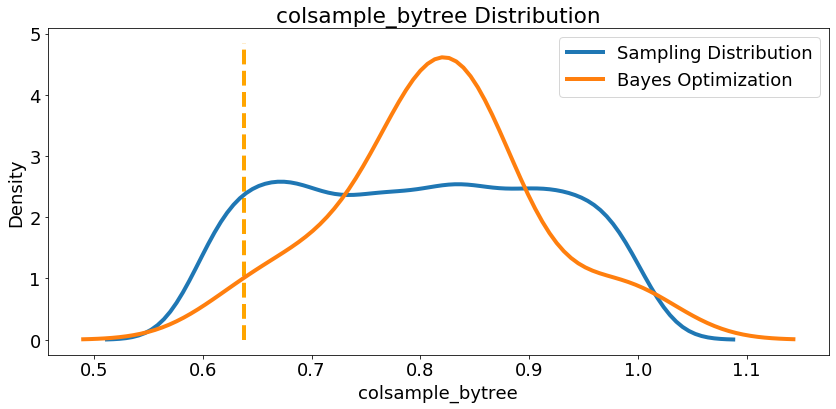

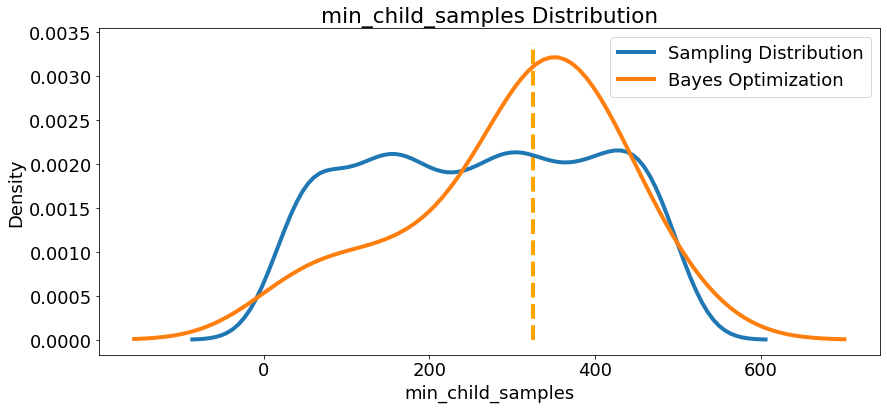

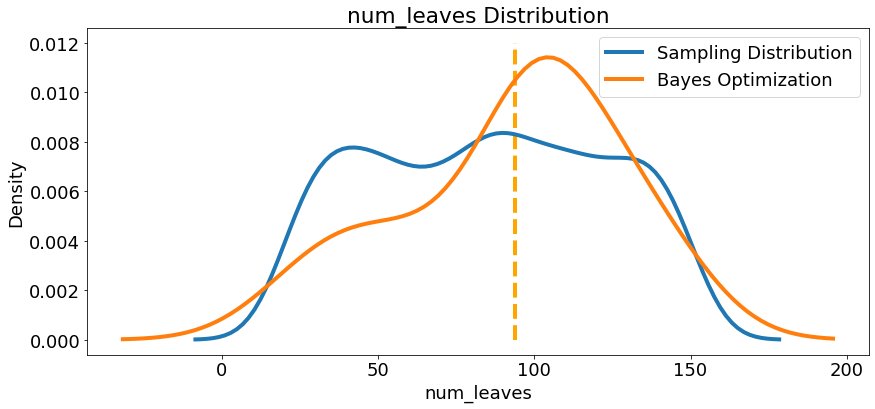

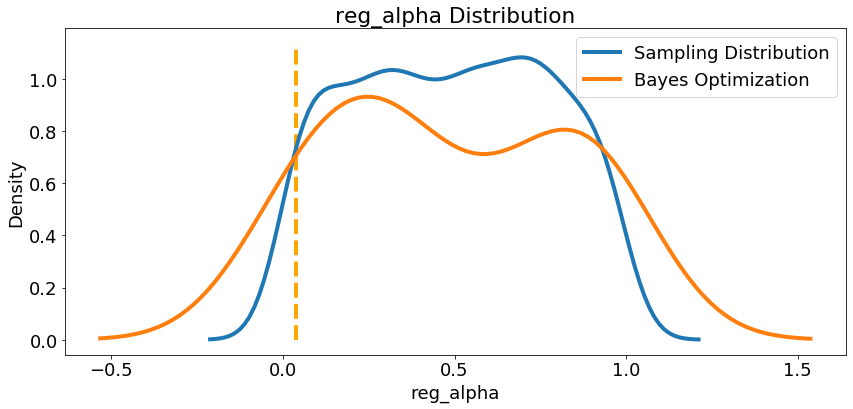

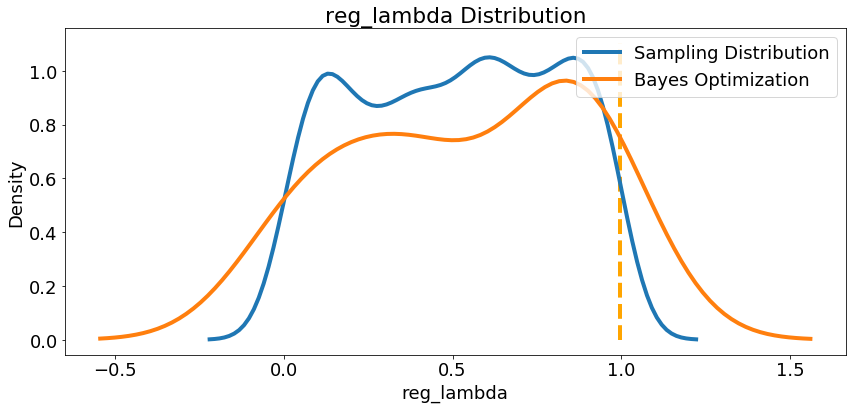

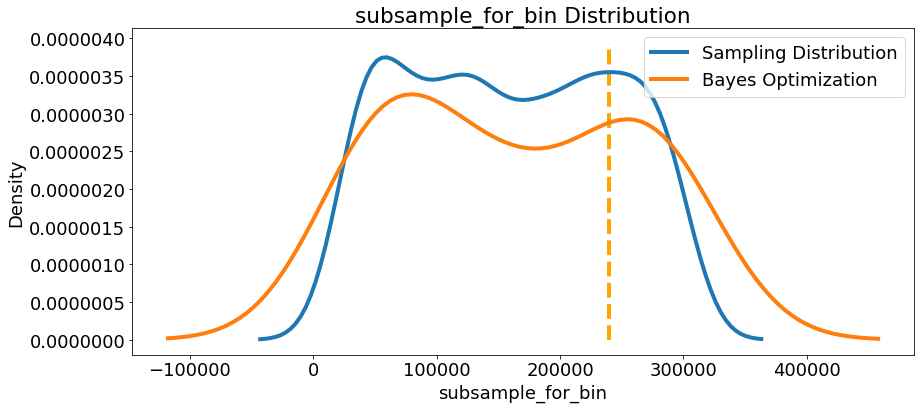

In [169]:
# Iterate through each hyperparameter
for i, hyper in enumerate(bayes_params.columns):
    if hyper not in ['class_weight', 'n_estimators', 'score', 'is_unbalance',
                    'boosting_type', 'iteration', 'subsample', 'metric', 'verbose', 'loss', 'learning_rate']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution', linewidth = 4)
        limit = sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization', linewidth = 4).get_ylim()[1]
        plt.vlines([best_bayes_params[hyper]],
                     ymin = 0.0, ymax = limit, linestyles = '--', linewidth = 4, colors = ['orange'])
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

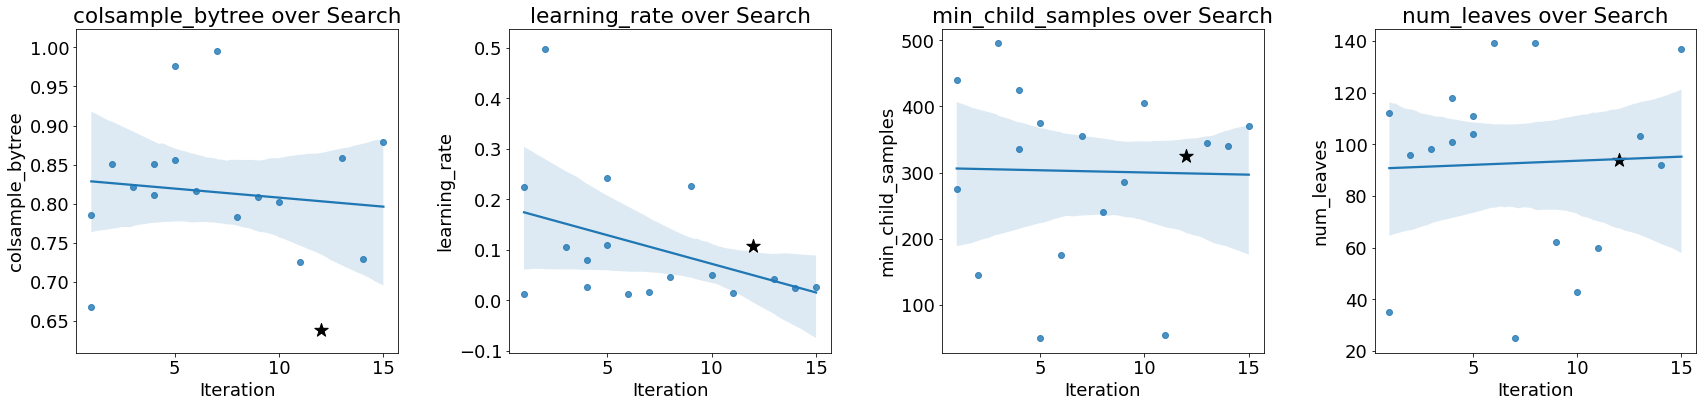

In [170]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

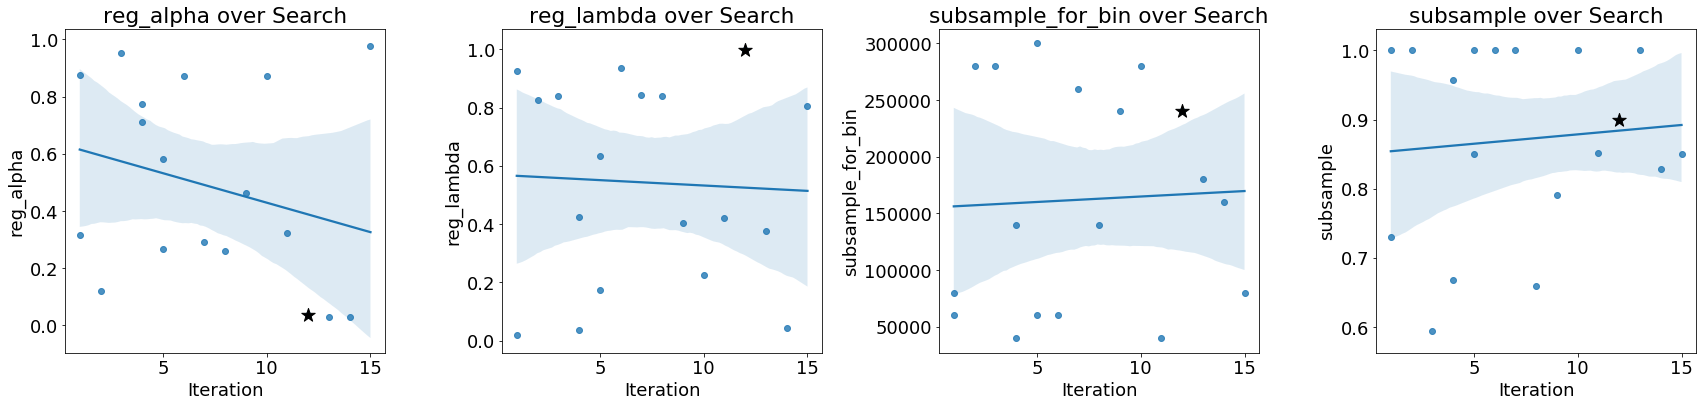

In [172]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin', 'subsample']):
            
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

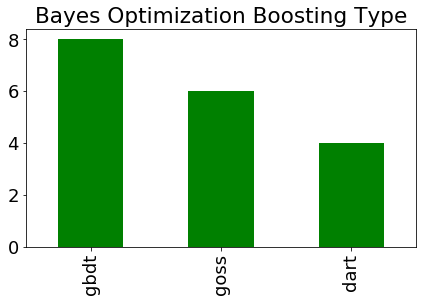

In [173]:
plt.figure()

# Bar plots of boosting type
bayes_params['boosting_type'].value_counts().plot.bar(figsize = (7, 4), color = 'green', title = 'Bayes Optimization Boosting Type');